#Install the transformers usign pip 

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import all required modules

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

#Read the dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_dataset.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


#Dataset information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


#Visualization the dataset labels

In [6]:
import matplotlib.pyplot as plt

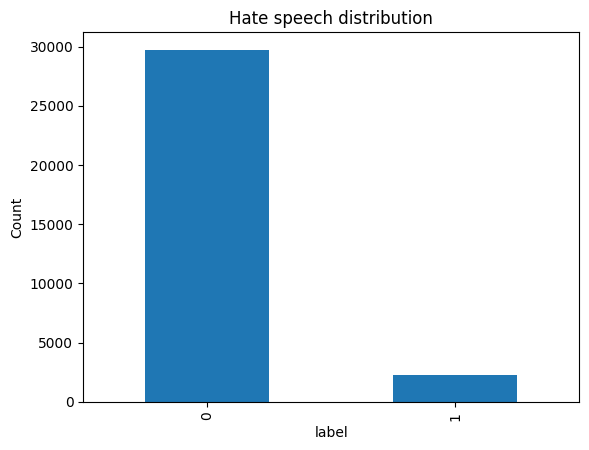

In [7]:
# count the values and plot a bar chart
value_counts = df['label'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Hate speech distribution')
plt.show()

#Bert model initialization

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#Converting the text data into bert model tokens

In [9]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [10]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['tweet'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

#Apply one-hot encoding on labels

In [11]:
labels = np.zeros((len(df), 2))
labels.shape

(31962, 2)

In [12]:
labels[np.arange(len(df)), df['label'].values] = 1 # one-hot encoded target tensor

In [13]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [15]:
def HateSpeechDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

# converting to required format for tensorflow dataset 

In [16]:
dataset = dataset.map(HateSpeechDatasetMapFunction) 

In [17]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [18]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

In [19]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

#Splitting the data into training and validation

In [20]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [21]:
train_size
     

1597

#Required training and validation datasets

In [22]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [23]:
from transformers import TFBertModel

In [24]:
model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(2, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [26]:

optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [27]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [28]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4
)

Epoch 1/4
1597/1597 [==============================] - 1390s 863ms/step - loss: 0.1320 - accuracy: 0.9550 - val_loss: 0.0691 - val_accuracy: 0.9753
Epoch 2/4
1597/1597 [==============================] - 1383s 866ms/step - loss: 0.0714 - accuracy: 0.9749 - val_loss: 0.0375 - val_accuracy: 0.9867
Epoch 3/4
1597/1597 [==============================] - 1383s 866ms/step - loss: 0.0383 - accuracy: 0.9872 - val_loss: 0.0263 - val_accuracy: 0.9927
Epoch 4/4
1597/1597 [==============================] - 1414s 886ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0124 - val_accuracy: 0.9975


#visualizing the loss

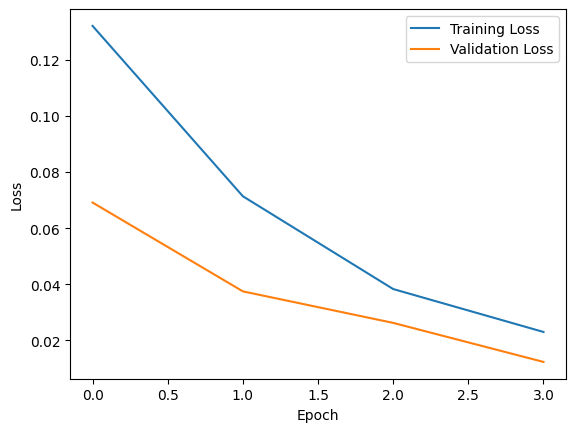

In [29]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#visualizing the accuracy

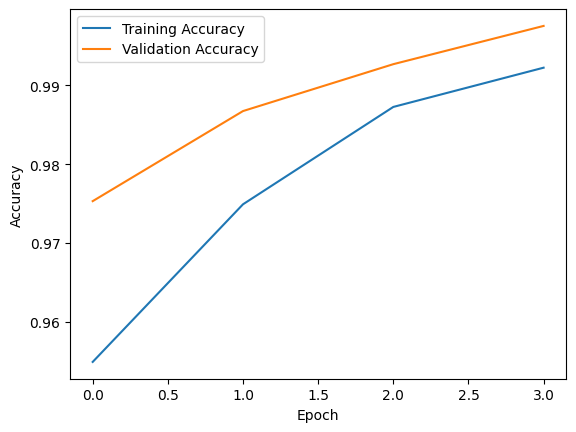

In [30]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
sentiment_model.save('sentiment_model')

In [32]:
sentiment_model = tf.keras.models.load_model('sentiment_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [34]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_dataset.csv')
df1.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [35]:
df1.shape

(17197, 2)

In [36]:
l=[]
for i in df1['tweet']:
    l.append(i)

In [37]:
l

['#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ\x80¦ ',
 ' @user #white #supremacists want everyone to see the new â\x80\x98  #birdsâ\x80\x99 #movie â\x80\x94 and hereâ\x80\x99s why  ',
 'safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!! ',
 'is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8d   #harrypotter #pottermore #favorite',
 '  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ\x80¦ ',
 'choose to be   :) #momtips ',
 'something inside me dies ð\x9f\x92¦ð\x9f\x92¿â\x9c¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ\x80¦ ',
 '#finished#tattoo#inked#ink#loveitâ\x9d¤ï¸\x8f #â\x9d¤ï¸\x8fâ\x9d¤ï¸\x8fâ\x9d¤ï¸\x8fâ\x9d¤ï¸\x8f #thanks#aleeee !!! ',
 ' @user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels  ',
 '#delicious   #food #lovelife #capetown 

In [38]:
classes=['non-hate','hate']
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

In [ ]:
count=0
for i in l:
    tokenized_data=prepare_data(i,tokenizer)
    output=sentiment_model.predict(tokenized_data)
    n=np.argmax(output)
    if(n==1):
        count=count+1
    print(classes[n])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 72ms/step
non-hate
1/1 [==============================] - 0s 71ms/step
hate
1/1 [==============================] - 0s 69ms/step
non-hate
1/1 [==============================] - 0s 71ms/step
non-hate
1/1 [==============================] - 0s 69ms/step
non-hate
1/1 [==============================] - 0s 69ms/step
non-hate
1/1 [==============================] - 0s 70ms/step
non-hate
1/1 [==============================] - 0s 71ms/step
non-hate
1/1 [==============================] - 0s 76ms/step
non-hate
1/1 [==============================] - 0s 75ms/step
non-hate
1/1 [==============================] - 0s 77ms/step
non-hate
1/1 [==============================] - 0s 67ms/step
non-hate
1/1 [==============================] - 0s 68ms/step
non-hate
1/1 [==============================] - 0s 72ms/step
non-hate
1/1 [==============================] - 0s 77ms/step
non-hate
1/1 [==============================] -

In [40]:
print(count)

937
